<a href="https://colab.research.google.com/github/Bogdanfl935/Cryptocurrency-Price-Prediction/blob/main/Cryptocurrency_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet fastquant

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import fastquant as fq
import datetime as dt

start = dt.date(2019, 1, 1)
end = dt.date(2022, 1, 1)
exchange = 'BTC/USDT'

raw_crypto_price = fq.get_crypto_data(exchange, str(start), str(end))
crypto_price = raw_crypto_price[["close"]].reset_index()

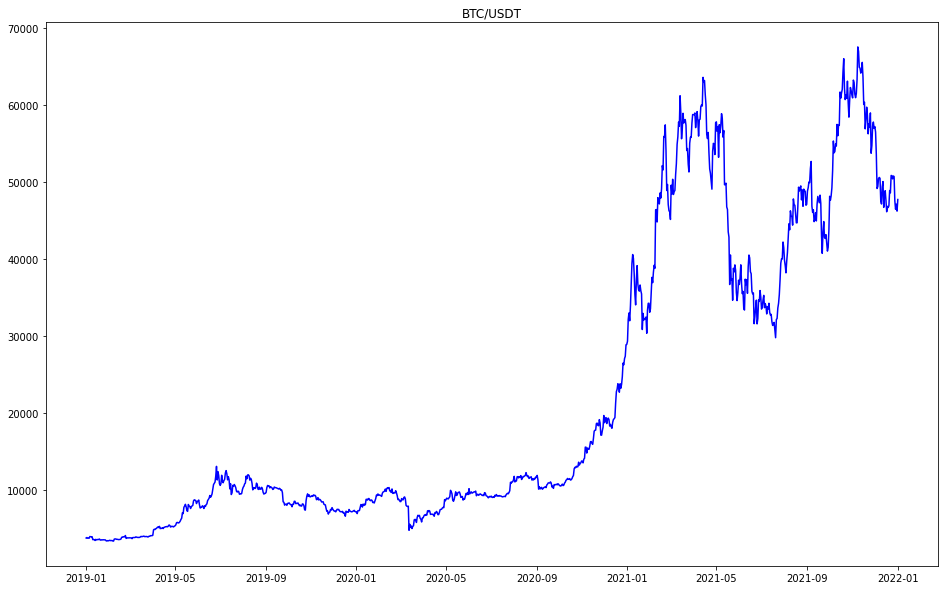

In [4]:
plt.figure(figsize=(16, 10))
plt.plot(crypto_price['dt'], crypto_price['close'], 'b')
plt.title(exchange)
plt.show()

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_close = scaler.fit_transform(crypto_price[['close']])

In [6]:
WINDOW_SIZE = 7
train_data = np.array([normalized_close[i-WINDOW_SIZE:i] for i in range(WINDOW_SIZE, len(normalized_close))])
pred_data = np.array([normalized_close[i] for i in range(WINDOW_SIZE, len(normalized_close))])
train_data.shape

(1090, 7, 1)

In [7]:
model = keras.Sequential(
    [
        layers.LSTM(units=50, return_sequences=True, input_shape=train_data.shape[1:]),
        layers.Dropout(0.2),
        layers.LSTM(units=50, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(units=50),
        layers.Dropout(0.2),
        layers.Dense(units=1),
    ]
)

In [8]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [9]:
BATCH_SIZE = 32
EPOCHS = 50
model.fit(train_data, pred_data, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/50
35/35 [==============================] - 8s 7ms/step - loss: 0.0468
Epoch 2/50
35/35 [==============================] - 0s 7ms/step - loss: 0.0051
Epoch 3/50
35/35 [==============================] - 0s 7ms/step - loss: 0.0037
Epoch 4/50
35/35 [==============================] - 0s 7ms/step - loss: 0.0037
Epoch 5/50
35/35 [==============================] - 0s 7ms/step - loss: 0.0031
Epoch 6/50
35/35 [==============================] - 0s 7ms/step - loss: 0.0029
Epoch 7/50
35/35 [==============================] - 0s 7ms/step - loss: 0.0028
Epoch 8/50
35/35 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 9/50
35/35 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 10/50
35/35 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 11/50
35/35 [==============================] - 0s 7ms/step - loss: 0.0028
Epoch 12/50
35/35 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 13/50
35/35 [==============================

In [10]:
test_start = dt.date(2021, 12, 1)
PREDICTION_INTERVAL = 365
test_end = test_start + dt.timedelta(days=PREDICTION_INTERVAL)
raw_crypto_test_price = fq.get_crypto_data(exchange, str(test_start), str(test_end))
crypto_test_price = raw_crypto_test_price[["close"]].reset_index()

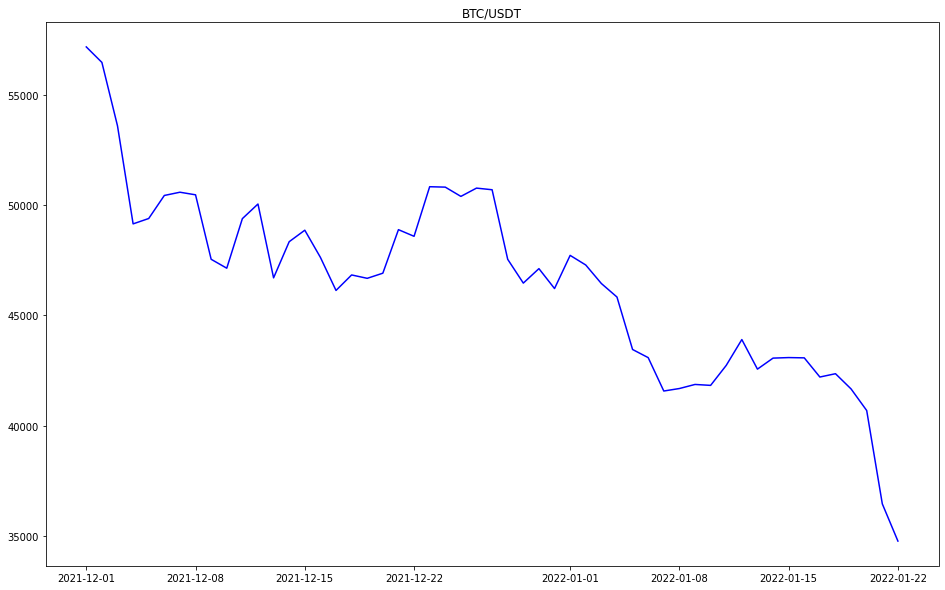

In [11]:
plt.figure(figsize=(16, 10))
plt.plot(crypto_test_price['dt'], crypto_test_price['close'], 'b')
plt.title(exchange)
plt.show()

In [ ]:
normalized_test_close = scaler.fit_transform(crypto_test_price[['close']])
test_data = np.array([normalized_test_close[i-WINDOW_SIZE:i] for i in range(WINDOW_SIZE, len(normalized_test_close))])
test_data

In [13]:
buys = {}
sells = {}
predictions = {}

for i in range(len(test_data)):
    pred_price = scaler.inverse_transform(model.predict(test_data[i][np.newaxis]))
    unnormalized_last_price = scaler.inverse_transform(test_data[i][:])[-1]
    if pred_price > unnormalized_last_price:
        buys[WINDOW_SIZE+i-1] = unnormalized_last_price[-1]
    elif pred_price < unnormalized_last_price:
        sells[WINDOW_SIZE+i-1] = unnormalized_last_price[-1]
    predictions[WINDOW_SIZE+i] = pred_price[-1]

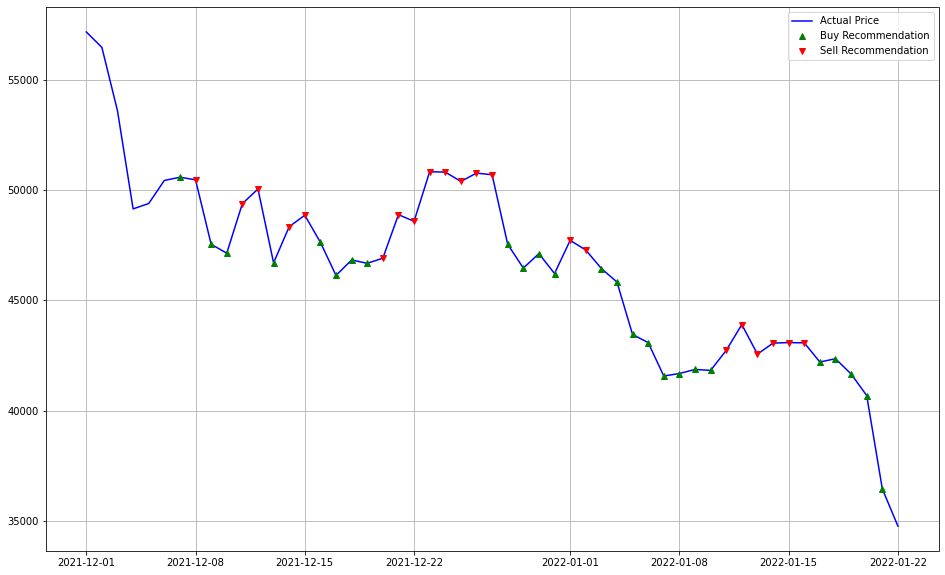

In [14]:
plt.figure(figsize=(16, 10))
plt.plot(crypto_test_price['dt'], crypto_test_price['close'], 'b', label="Actual Price")
plt.plot([test_start + dt.timedelta(days=key) for key in buys.keys()], list(buys.values()), "^", color="g", label="Buy Recommendation")
plt.plot([test_start + dt.timedelta(days=key) for key in sells.keys()], list(sells.values()), "v", color="r", label="Sell Recommendation")
plt.legend()
plt.grid(True)

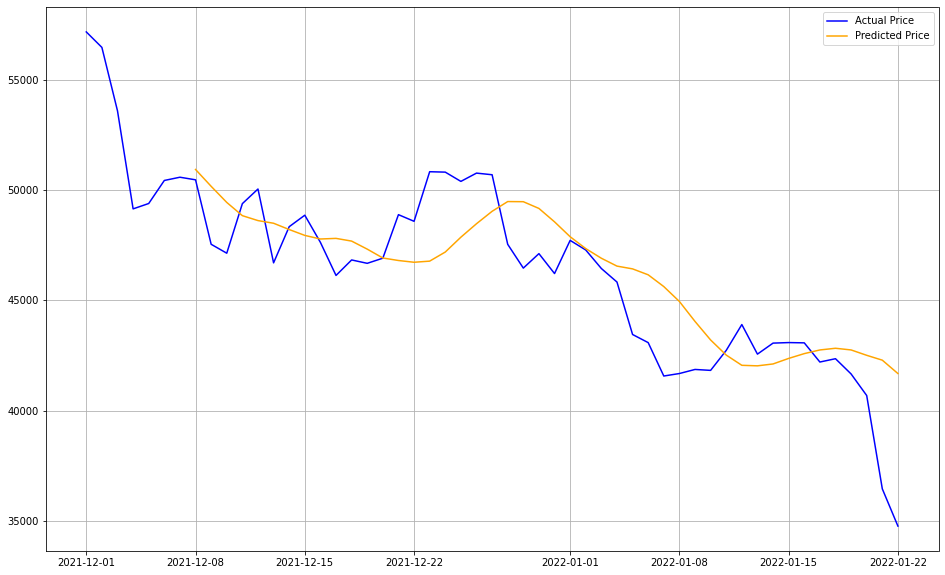

In [15]:
plt.figure(figsize=(16, 10))
plt.plot(crypto_test_price['dt'], crypto_test_price['close'], 'b', label="Actual Price")
plt.plot([test_start + dt.timedelta(days=key) for key in predictions.keys()], list(predictions.values()), color='orange', label="Predicted Price")
plt.legend()
plt.grid(True)